# Channel Capacity and Random Coding
The purpose behind this notebook is to get some intuition behind the operational meaning of the channel capacity. To that end, we will use something called random coding, where the main idea is to design codebooks by choosing each symbol at random according to the capacity-achieving input distribution.  

It may be somewhat surprising that this way we can actually design quite "good" coding schemes with just a few simple lines of Python code. The caveat is that these schemes will have very low rates. Nonetheless, the important thing is that, at least in principle, the exact same random coding procedure also works for higher rates, and this is in fact how one can proof the channel coding theorem. 

## The AWGN Channel

We will start by considering the discrete-time real-valued additive white Gaussian noise (AWGN) channel $y = x + n$, where $x \in \mathbb{R}$ is the channel input, $n \sim \mathcal{N}(0, \sigma^2)$ is Gaussian noise, and $y \in \mathbb{R}$ is the channel output. Assuming that the input $x$ has to satisfy the input constraint $\mathbb{E}[X^2] \leq E_s$, the capacity for this channel is 

$$C = \frac{1}{2} \log_2(1 + \text{SNR}), $$

where $\text{SNR} = E_s/\sigma^2$. In the following, we assume that $E_s = 1$ without loss of generality. 

In [1]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

First, we define our code parameters, where $R = \log_2(M)/N$, $M$ is the number of codewords, and $N$ is the length of each codeword. Here, M is computed based on the chosen $R$ and $N$. 

In [27]:
R = 0.01 # we have to pick a very low rate for this to work
N = 1000 # codeword length
M = int(2**(R*N)) # M is the number of codewords and log2(M) is the number of corresponding transmitted bits
print('number of messages: M = {}'.format(M))

number of messages: M = 1024


After we have fixed our desired code parameters, we can resort to the above capacity formula in order to calculate how much SNR we need for reliable transmission. 

In [28]:
SNRc = 2**(2*R)-1 # SNR = 1/sigma2
SNRc_dB = 10*np.log10(SNRc)
sigma2_cap = 1/SNRc
print('To support a transmission rate R = {} [bits/channel use], we need at least SNR = {:.2f} dB'.format(R, SNRc_dB))

To support a transmission rate R = 0.01 [bits/channel use], we need at least SNR = -18.55 dB


### Codebook Generation

We consider two different types of codebooks: 
- The first is based on Gaussian symbols, according to the capacity-achieving input distribution
- The second is based on binary BPSK signaling, i.e., either +1 or -1 with equal probability. We know that for low rates (power-limited regime) the performance penality will be very small (try it!). 

In [6]:
def generate_codebook(M, N):
    return np.random.normal(0, 1, size=[M, N]) # every row is a codword (of length N)

def generate_bpsk_codebook(M, N): 
    return 1-2*np.random.randint(0, 2, size=[M, N]) # every row is a codword (of length N)

*How can we transmit anything useful if all the codewords are just random and look like noise?* This is a common misconception regarding random coding. However, it is important to realize that, once we have generated the codebook, it is assumed to be fixed and available at both the transmitter and receiver. After this point, the encoding process is not at all "random" anymore but consists of a deterministic mapping from our messages (or, equivalently, from a sequence of information bits) to individual codewords. 

Let us illustrate this. First we generate the codebook: 

In [23]:
C = generate_codebook(M, N)

From now on, we assume that the codebook is fixed and known at the transmitter and receiver. We can for example check if the codebook satisfies (approximately) our constraint for the average symbol energy (which we assume is normalized to 1): 

In [8]:
np.mean(C**2, axis=1) # check that the average symbol energy for each codeword is close to 1

array([0.9882526 , 0.99284075, 0.93109079, ..., 1.04274522, 0.9518482 ,
       0.96682781])

There may be some slight deviations from 1 so we could renormalize by the maximum to strictly enforce the constraint. However, let us proceed without renormalization to keep it simple. 


### Transmission and Decoding
Next, let's pick a message at random and transmit it over the channel: 

In [9]:
m = np.random.randint(0, M) # pick a message at random
x = C[m,:] # select the corresponding codeword
y = x + np.random.normal(0, np.sqrt(sigma2_cap/100), size=[N]) # transmit over the AWGN channel 

Now we have to decode the message. Decoding means to select the most likely message, given the received observation $\boldsymbol{y}$. The optimal decoder in this case can be shown to be the minimum (Euclidean) distance decoder. For our randomly generated codebook, we have to resort to brute-force computing of the Euclidean distance (or squared Euclidean distance) between the observation and each codeword and then picking the minimum: 

In [10]:
m_hat = np.argmin(np.mean((C-y)**2, axis=1)) # minimum (Euclidean) distance decoding

In [11]:
print('Transmitted message: {}'.format(m))
print('Received message: {}'.format(m))

Transmitted message: 259
Received message: 259


Since we picked the SNR far higher than the capacity limit (scaling down the noise variance $\sigma^2$ by a factor 100), it is very likely that we correctly decoded the message. 

### Monte Carlo Evaluation of the Error Probability

The following function combines the entire end-to-end simulation for a single codeword. It returns 0 if the message was transmitted correctly and 1 if there was an error. 

In [24]:
def transmit_one_codeword(sigma2):
    m = np.random.randint(0, M)
    x = C[m,:] # select a random codeword
    y = x + np.random.normal(0, np.sqrt(sigma2), size=[N]) # transmit over the channel 
    m_hat = np.argmin(np.mean((C-y)**2, axis=1)) # minimum (Euclidean) distance decoding
    return int(m_hat != m)

From this, we can estimate the error probablity using Monte Carlo evaluation for different SNRs that are "close" to the capacity limit:

In [25]:
dB_off = np.arange(-6, 8, 2)
LL = dB_off.shape[0]
KK = 1500 # number of codewords for each Monte Carlo evaluation
Pe = np.zeros(LL)

for i in tqdm(range(LL)):
    tmp = 0
    SNR_dB = SNRc_dB + dB_off[i]
    sigma2 = 1/10**(SNR_dB/10)
    for j in range(KK): 
        tmp = tmp + transmit_one_codeword(sigma2)
    Pe[i] = tmp/KK

In [21]:
Pe_save = Pe # save a previous run to compare different values for N

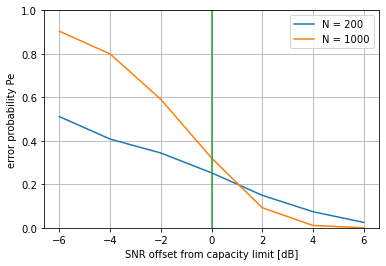

In [26]:
plt.plot(dB_off, Pe_save, label='N = 200')
plt.plot(dB_off, Pe, label='N = {}'.format(N))
plt.plot([0, 0], [0, 1])
plt.ylabel('error probability Pe')
plt.xlabel('SNR offset from capacity limit [dB]')
plt.ylim(0,1)
plt.grid()
plt.legend()
plt.show()

From the above figure, we can see what happens as $N$ increases: The curves become more steep. Eventually, as $N \to \infty$, the curves will exhibit a sharp threshold behavior, precisely at the capacity limit. In other words, reliable communication with arbitrarily low error rates is possible only if the SNR is chosen larger than the limit. This is the operational meaning of the channel capacity. 

Random coding can indeed approach the capacity (and it is used in proofs), but it is impractical to implement in a real system. For example, increasing the $N$ beyond 1000 will eventually lead to memory issues, since random coding requires us to store the entire codebook. 

# The Binary Symmetric Channel (BSC)

We can proceed in pretty much the same also for the BSC, starting with the code parameters:

In [43]:
R = 0.01 # we have to pick a very low rate for this to work
N = 1000 # codeword length
M = int(2**(R*N)) # M is the number of codewords and log2(M) is the number of corresponding transmitted bits
print('number of messages: M = {}'.format(M))

number of messages: M = 1024


For the BSC with error probability $p$, we recall that the channel capacity is

$$ C = 1 - H_b(p), $$

where $H_b(p)$ is the binary entropy function:

In [33]:
def BinEntropy(p): 
    if p <= 0: 
        return 0
    elif p >= 0.5:
        return 1
    else:
        return p*np.log2(1/p)+(1-p)*np.log2(1/(1-p))

Unlike for the AWGN channel, there is unfortunately no closed-form solution to invert this expression and find the minimum $p$ required to support a given rate $R$. Therefore, we have to resort to numerical inversion: 

In [34]:
def MyF(t, *data):
    return (1 - BinEntropy(t)) - data[0]

def BinEntropyInv(R): 
    if R <= 0: 
        return 0
    if R >= 1:
        return 0.5
    myfun = (BinEntropy(t) - R)
    return fzero(myfun, [0.2])

In [35]:
p_cap = fsolve(MyF, 0.0, args=R)
print(p_cap)

[0.44119761]


Sanity check that this gives indeed the desired rate: 

In [36]:
1-BinEntropy(p_cap)

array([0.01])

### Codebook Generation

The codebook generation works similar to before, but now all symbols are IID bits with $Pr(0) = Pr(1) = 0.5$ which is the capacity-achieving input distribution for the BSC:

In [44]:
def generate_binary_codebook(M, N):
    return np.random.randint(0, 2, size=[M, N]) # every row is a binary codword (of length N)

In [45]:
C = generate_binary_codebook(M, N)

### Monte Carlo Evaluation

The main difference compared to the AWGN is that optimal decoding corresponds to minimum Hamming distance decoding. The general procedure, however, is the same: compare the received word with each codeword in the codebook in terms of Hamming distance, and then choose the minimum. 

In [46]:
def transmit_one_codeword(p):
    m = np.random.randint(0, M)
    x = C[m,:] # select a random codeword
    n = (np.random.uniform(0, 1, size=[N]) < p).astype(int)
    y = np.mod(x + n, 2) # transmit over the channel 
    m_hat = np.argmin(np.sum(np.mod(C+y, 2), axis=1)) # minimum (Hamming) distance decoding
    return int(m_hat != m)

In [47]:
p_off = np.arange(-0.06, 0.07, 0.02)

LL = p_off.shape[0]
KK = 1500 # number of codewords for each Monte Carlo evaluation
Pe = np.zeros(LL)

for i in tqdm(range(LL)):
    tmp = 0
    p = p_cap + p_off[i]
    for j in range(KK): 
        tmp = tmp + transmit_one_codeword(p)
    Pe[i] = tmp/KK

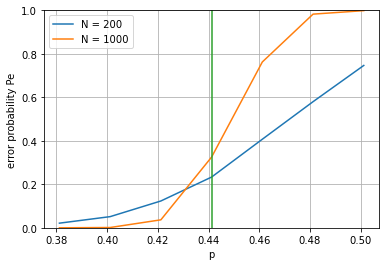

In [48]:
plt.plot(p_cap+p_off, Pe_save, label='N = 200')
plt.plot(p_cap+p_off, Pe, label='N = {}'.format(N))
plt.plot([p_cap, p_cap], [0, 1])
plt.ylabel('error probability Pe')
plt.xlabel('p')
plt.ylim(0,1)
plt.grid()
plt.legend()
plt.show()

In [42]:
Pe_save = Pe